In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import gdreg
import time
import pgenlib as pg

%load_ext autoreload
%autoreload 2

In [32]:
PGEN_FILE = "/n/scratch3/users/j/jz286/imp_geno/ukb_imp_chr@_v3"
AA_FILE = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/snp_info/ukb_imp_chr@_va-ancestral_annot.pvar'
dic_map = {'A':'A', 'a':'A', 'T':'T', 't':'T', 'C':'C', 'c':'C', 'G':'G', 'g':'G'}

# for CHR in [22]:
for CHR in range(1,23):
    print('CHR%d' % CHR)
    df_snp_chr = gdreg.util.read_pgen(PGEN_FILE.replace("@", "%d" % CHR))["pvar"].copy()
    df_snp_chr['MAF'] = gdreg.util.read_pgen(
        PGEN_FILE.replace("@", "%d"%CHR))["afreq"]["MAF"].astype(np.float32)
    df_aa = pd.read_csv(AA_FILE.replace('@', '%d'%CHR), sep='\t')
    
    dic_aa = {x:dic_map[y] for x,y in zip(df_aa['ID'], df_aa['AA']) if y in dic_map}
    dic_chimp = {x:dic_map[y] for x,y in zip(df_aa['ID'], df_aa['Chimp']) if y in dic_map}
    df_snp_chr['AA'] = [dic_aa[x] if x in dic_aa else 'NA' for x in df_snp_chr['SNP']]
    df_snp_chr['Chimp'] = [dic_chimp[x] if x in dic_chimp else 'NA' for x in df_snp_chr['SNP']]

    df_snp_chr['REF_AA'] = [z if z in [x,y] else x
        for x,y,z in zip(df_snp_chr['REF'], df_snp_chr['ALT'], df_snp_chr['AA'])
    ]
    df_snp_chr['REF_Chimp'] = [z if z in [x,y] else x
        for x,y,z in zip(df_snp_chr['REF'], df_snp_chr['ALT'], df_snp_chr['Chimp'])
    ]
    df_snp_chr.to_csv(
        '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/snp_info/ukb_imp_chr%d_v3_aa.pvar'%CHR,
        sep='\t', index=False
    )

CHR1
CHR2
CHR3
CHR4
CHR5
CHR6
CHR7
CHR8
CHR9
CHR10
CHR11
CHR12
CHR13
CHR14
CHR15
CHR16
CHR17
CHR18
CHR19
CHR20
CHR21
CHR22


In [3]:
# Check consistency
dic_mbin = {'all' : [0, 1], 'rare': [0, 0.005], 'lf': [0.005, 0.05], 'common' : [0.05, 1]}
for col in ['AA', 'Chimp']:
    for mbin in dic_mbin:
        ind_select = (df_snp_chr['MAF']>=dic_mbin[mbin][0]) & (df_snp_chr['MAF']<=dic_mbin[mbin][1])
        print('%s %s n_snp=%d' % (col, mbin, ind_select.sum()))
        print('    REF=%d, ALT=%d, missing=%d, ' % (
            (df_snp_chr.loc[ind_select, col]==df_snp_chr.loc[ind_select, 'REF']).sum(),
            (df_snp_chr.loc[ind_select, col]==df_snp_chr.loc[ind_select, 'ALT']).sum(),
            (df_snp_chr.loc[ind_select, col]=='NA').sum(),
        ))
        
    print('')

AA all n_snp=199680
    REF=138744, ALT=24772, missing=33446, 
AA rare n_snp=55426
    REF=42417, ALT=1186, missing=11271, 
AA lf n_snp=55916
    REF=44130, ALT=3116, missing=7916, 
AA common n_snp=88338
    REF=52197, ALT=20470, missing=14259, 

Chimp all n_snp=199680
    REF=151436, ALT=38011, missing=7760, 
Chimp rare n_snp=55426
    REF=48601, ALT=4394, missing=1845, 
Chimp lf n_snp=55916
    REF=46121, ALT=6885, missing=2224, 
Chimp common n_snp=88338
    REF=56714, ALT=26732, missing=3691, 



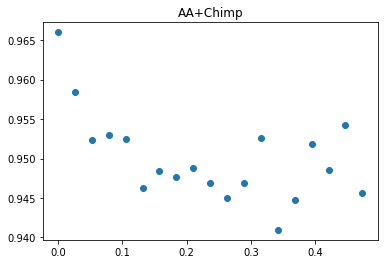

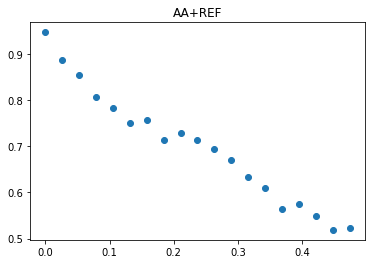

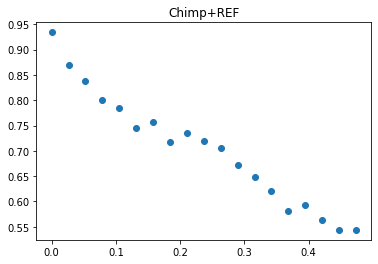

In [4]:
# Check consistency
dic_mbin = {'all' : [0, 1], 'rare': [0, 0.005], 'lf': [0.005, 0.05], 'common' : [0.05, 1]}
maf_bin_list = np.linspace(0,0.5,20)
for term1,term2 in [['AA', 'Chimp'], ['AA', 'REF'], ['Chimp', 'REF']]:
    yval = []
    for i in range(len(maf_bin_list)-1):
        maf_lb = maf_bin_list[i]
        maf_ub = maf_bin_list[i+1]
        ind_maf = (df_snp_chr['MAF']>=maf_lb) & (df_snp_chr['MAF']<=maf_ub)
        ind_nonmissing = (df_snp_chr[term1].isin(['A','T','C','G'])) & \
            (df_snp_chr[term2].isin(['A','T','C','G']))
        ind_select = ind_maf & ind_nonmissing
        yval.append( (df_snp_chr.loc[ind_select, term1]==df_snp_chr.loc[ind_select, term2]).sum()
                    / ind_select.sum())
        
    plt.figure()
    plt.scatter(maf_bin_list[:-1], yval)
    plt.title(term1 + '+' + term2)
    plt.show()

### Check plink file

In [3]:
# Directly using --ref-allele is not compatible with pgenlib
pgen_file = '/n/scratch3/users/j/jz286/imp_geno_chimp/ukb_imp_chr22_v3_chimp.pgen'
with pg.PgenReader(bytes(pgen_file, encoding="utf8")) as reader:
    mat_X = np.empty([10, 337426], np.int8)
    reader.read_range(0, 10, mat_X)

In [5]:
# Check 
CHR = 22
PGEN_FILE = "/n/scratch3/users/j/jz286/imp_geno/ukb_imp_chr@_v3"
PGEN_FILE_CHIMP = "/n/scratch3/users/j/jz286/imp_geno_chimp/ukb_imp_chr@_v3_chimp"
REF_FILE = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/snp_info/ukb_imp_chr@_v3_aa.pvar'

dic_data = gdreg.util.read_pgen(PGEN_FILE.replace("@", "%d" % CHR))
dic_data_chimp = gdreg.util.read_pgen(PGEN_FILE_CHIMP.replace("@", "%d" % CHR))
df_ref = pd.read_csv(REF_FILE.replace('@', '%d'%CHR), sep='\t')

In [8]:
# Consistency of ref allele
print('CHIMP vs. REF_Chimp : n_dif=%d' % (dic_data_chimp['pvar']['REF']!=df_ref['REF_Chimp']).sum())
print('CHIMP vs. REF_AA : n_dif=%d' % (dic_data_chimp['pvar']['REF']!=df_ref['REF_AA']).sum())
print('CHIMP vs. REF : n_dif=%d' % (dic_data_chimp['pvar']['REF']!=df_ref['REF']).sum() )
print('Original vs. REF : n_dif=%d' % (dic_data['pvar']['REF']!=df_ref['REF']).sum() )

CHIMP vs. REF_Chimp : n_dif=0
CHIMP vs. REF_AA : n_dif=16763
CHIMP vs. REF : n_dif=38011
Original vs. REF : n_dif=0


In [10]:
# Consistency of genotype
n_snp = 200
mat_X = gdreg.util.read_geno(dic_data['pgen'], 0, n_snp).T.astype(int)
mat_X_chimp = gdreg.util.read_geno(dic_data_chimp['pgen'], 0, n_snp).T.astype(int)

ind_dif = (mat_X != mat_X_chimp).sum(axis=0) > 0
ind_dif_ref = (dic_data_chimp['pvar']['REF'] != dic_data['pvar']['REF']).values

print('n_flip=%d' % ind_dif_ref[:n_snp].sum())
print('n_consistent=%d/%d' % ((ind_dif_ref[:n_snp]==ind_dif).sum(), n_snp))

n_flip=8
n_consistent=200/200


### Old code

In [2]:
CHR = 22
PGEN_FILE = "/n/scratch3/users/j/jz286/imp_geno/ukb_imp_chr@_v3"
AA_FILE = '/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/snp_info/ukb_imp_chr@_va-ancestral_annot.pvar'
df_snp_chr = gdreg.util.read_pgen(PGEN_FILE.replace("@", "%d" % CHR))["pvar"].copy()
df_snp_chr['MAF'] = gdreg.util.read_pgen(
    PGEN_FILE.replace("@", "%d" % CHR))["afreq"]["MAF"].astype(np.float32)
df_aa = pd.read_csv(AA_FILE.replace('@', '%d'%CHR), sep='\t')

In [6]:
dic_map = {'A':'A', 'a':'A', 'T':'T', 't':'T', 'C':'C', 'c':'C', 'G':'G', 'g':'G'}
dic_aa = {x:dic_map[y] for x,y in zip(df_aa['ID'], df_aa['AA']) if y in dic_map}
dic_chimp = {x:dic_map[y] for x,y in zip(df_aa['ID'], df_aa['Chimp']) if y in dic_map}

df_snp_chr['AA'] = [dic_aa[x] if x in dic_aa else '' for x in df_snp_chr['SNP']]
df_snp_chr['Chimp'] = [dic_chimp[x] if x in dic_chimp else '' for x in df_snp_chr['SNP']]


df_snp_chr['REF_AA'] = [z if z in [x,y] else x
    for x,y,z in zip(df_snp_chr['REF'], df_snp_chr['ALT'], df_snp_chr['AA'])
]
df_snp_chr['REF_Chimp'] = [z if z in [x,y] else x
    for x,y,z in zip(df_snp_chr['REF'], df_snp_chr['ALT'], df_snp_chr['Chimp'])
]
df_snp_chr.to_csv('/n/groups/price/martin/data_GDREG/UKBimp_337K_MAF001/snp_info/ukb_imp_chr%d_v3_aa.pvar' % CHR)

In [16]:
(df_snp_chr['MAF']>0.49dd).sum()

1600

In [20]:
df_snp_chr

,CHR,BP,SNP,REF,ALT,MAF,AA,Chimp,REF_AA,REF_Chimp
0,22,16050527,rs587769434,C,A,0.001391,,C,C,C
1,22,16051249,rs62224609,T,C,0.100340,,T,T,T
2,22,16053862,rs62224614,C,T,0.101977,,C,C,C
3,22,16054454,rs7286962,C,T,0.105103,,C,C,C
4,22,16056406,22:16056406_C_T,C,T,0.001328,,A,C,C
...,...,...,...,...,...,...,...,...,...,...
199675,22,51237712,rs370652263,G,A,0.055025,,G,G,G
199676,22,51238318,rs541098394,A,T,0.003576,,,A,A
199677,22,51238328,rs553081191,A,C,0.001977,,,A,A
199678,22,51238394,rs149712012,C,T,0.003899,,,C,C


In [13]:
# Check consistency
dic_mbin = {'all' : [0, 1], 'rare': [0, 0.005], 'lf': [0.005, 0.05], 'common' : [0.05, 1]}
for col in ['AA', 'Chimp']:
    for mbin in dic_mbin:
        ind_select = (df_snp_chr['MAF']>=dic_mbin[mbin][0]) & (df_snp_chr['MAF']<=dic_mbin[mbin][1])
        print('%s %s n_snp=%d' % (col, mbin, ind_select.sum()))
        print('    REF=%d, ALT=%d, missing=%d, ' % (
            (df_snp_chr.loc[ind_select, col]==df_snp_chr.loc[ind_select, 'REF']).sum(),
            (df_snp_chr.loc[ind_select, col]==df_snp_chr.loc[ind_select, 'ALT']).sum(),
            (df_snp_chr.loc[ind_select, col]=='').sum(),
        ))
        
    print('')

AA all n_snp=199680
    REF=138744, ALT=24772, missing=33446, 
AA rare n_snp=55426
    REF=42417, ALT=1186, missing=11271, 
AA lf n_snp=55916
    REF=44130, ALT=3116, missing=7916, 
AA common n_snp=88338
    REF=52197, ALT=20470, missing=14259, 

Chimp all n_snp=199680
    REF=151436, ALT=38011, missing=7760, 
Chimp rare n_snp=55426
    REF=48601, ALT=4394, missing=1845, 
Chimp lf n_snp=55916
    REF=46121, ALT=6885, missing=2224, 
Chimp common n_snp=88338
    REF=56714, ALT=26732, missing=3691, 



In [37]:
print('AA=Chimp : %d/%d' % (
    (df_pvar['AA'] == df_pvar['Chimp']).sum(), ((df_pvar['Chimp']!='') & (df_pvar['AA']!='')).sum()
))

print('AA=REF : %d'%(df_pvar['AA']==df_pvar['REF']).sum())
print('AA=ALT : %d'%(df_pvar['AA']==df_pvar['ALT']).sum())
print('AA missing : %d'%(df_pvar['AA']=='').sum())
print('AA=other : %d'%
      ((df_pvar['AA']!=df_pvar['REF']) & (df_pvar['AA']!=df_pvar['ALT']) & (df_pvar['AA']!='')).sum())

print('Chimp=REF : %d'%(df_pvar['Chimp']==df_pvar['REF']).sum())
print('Chimp=ALT : %d'%(df_pvar['Chimp']==df_pvar['ALT']).sum())
print('Chimp missing : %d'%(df_pvar['Chimp']=='').sum())
print('Chimp=other : %d'%
      ((df_pvar['Chimp']!=df_pvar['REF']) & (df_pvar['Chimp']!=df_pvar['ALT']) & (df_pvar['Chimp']!='')).sum())

AA=Chimp : 159961/162634
AA=REF : 138744
AA=ALT : 24772
AA missing : 33446
AA=other : 2718
Chimp=REF : 151436
Chimp=ALT : 38011
Chimp missing : 7760
Chimp=other : 2473


In [26]:
df_pvar

,#CHROM,POS,ID,REF,ALT,AA,Chimp
0,22,16050527,rs587769434,C,A,,C
1,22,16051249,rs62224609,T,C,,T
2,22,16053862,rs62224614,C,T,,C
3,22,16054454,rs7286962,C,T,,C
4,22,16056406,22:16056406_C_T,C,T,,A
...,...,...,...,...,...,...,...
199675,22,51237712,rs370652263,G,A,,G
199676,22,51238318,rs541098394,A,T,,
199677,22,51238328,rs553081191,A,C,,
199678,22,51238394,rs149712012,C,T,,


In [6]:
df_aa

,#CHROM,POS,ID,REF,ALT,AA,Chimp
0,22,16050527,rs587769434,C,A,.,C
1,22,16051249,rs62224609,T,C,.,T
2,22,16053862,rs62224614,C,T,.,C
3,22,16054454,rs7286962,C,T,.,C
4,22,16056406,22:16056406_C_T,C,T,NaN,A
...,...,...,...,...,...,...,...
199724,22,51237712,rs370652263,G,A,.,G
199725,22,51238318,rs541098394,A,T,.,NaN
199726,22,51238328,rs553081191,A,C,.,NaN
199727,22,51238394,rs149712012,C,T,.,NaN


In [14]:
set(df_aa['AA'])

{'-', '.', '?', 'A', 'C', 'G', 'N', 'T', 'a', 'c', 'g', nan, 't', '|'}

In [15]:
set(df_aa['Chimp'])

{'.', 'A', 'C', 'G', 'T', nan}

In [7]:
len(set(df_aa['ID']))

199680